<a href="https://colab.research.google.com/github/Embeddediot/Pedictive-Maintenance/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TEST XOR FOR REPORT

In [ ]:
# import numpy as np
# import tensorflow as tf
# import matplotlib.pyplot as plt

# # XOR input and output
# X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
# y = np.array([[0], [1], [1], [0]])

# # Define the neural network model
# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(2, input_dim=2, activation='sigmoid'),  # Hidden layer with 2 neurons
#     tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer with 1 neuron
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Train the model
# history = model.fit(X, y, epochs=10000, verbose=0)

# # Plot training loss
# plt.plot(history.history['loss'])
# plt.title('Model Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.show()

# # Predicting the XOR output
# predictions = model.predict(X)
# print("Predictions:")
# print(predictions)

# # Visualize the decision boundary
# def plot_decision_boundary(model, X, y):
#     x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
#     y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
#     xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
#                          np.arange(y_min, y_max, 0.01))
#     grid = np.c_[xx.ravel(), yy.ravel()]
#     preds = model.predict(grid).reshape(xx.shape)

#     plt.contourf(xx, yy, preds, alpha=0.8)
#     plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), edgecolors='k', marker='o')
#     plt.title('Decision Boundary')
#     plt.xlabel('Input 1')
#     plt.ylabel('Input 2')
#     plt.show()

# plot_decision_boundary(model, X, y)


# Preproccessing data


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.fft import fft
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go

# Function to segment data
def segment_data(df, window_size, overlap):
    step_size = int(window_size * (1 - overlap))
    segments = []
    for start in range(0, len(df) - window_size + 1, step_size):
        segment = df.iloc[start:start + window_size]
        segments.append(segment)
    return segments

# Function to extract time-domain and frequency-domain features from segments
def extract_features(segment, sample_rate):
    features = {}
    for axis in ['X', 'Y', 'Z']:
        segment_axis = segment[axis].values  # Ensure alignment by converting to numpy array
        # features[f'{axis}_raw'] = segment_axis
        features[f'{axis}_mean'] = segment_axis.mean()
        features[f'{axis}_var'] = segment_axis.var()
        features[f'{axis}_skew'] = skew(segment_axis)
        features[f'{axis}_kurtosis'] = kurtosis(segment_axis)
        features[f'{axis}_mad'] = np.mean(np.abs(segment_axis - np.mean(segment_axis)))
        features[f'{axis}_rms'] = np.sqrt(np.mean(segment_axis**2))
        features[f'{axis}_peak'] = segment_axis.max()

        # Frequency domain features
        fft_values = np.abs(fft(segment_axis))[:len(segment)//2]  # only take positive frequencies
        freqs = np.fft.fftfreq(len(segment_axis), d=1/sample_rate)[:len(segment)//2]

        # Find the peak frequency and its magnitude
        peak_freq = freqs[np.argmax(fft_values)]
        peak_magnitude = np.max(fft_values)

        # Total power in specific frequency bands
        power_band_1 = np.sum(fft_values[(freqs >= 20) & (freqs < 70)])  # Example band: 20-70 Hz
        power_band_2 = np.sum(fft_values[(freqs >= 190) & (freqs < 230)])   # Example band: 190-230 Hz

        # FFT mean and variance
        features[f'{axis}_fft_mean'] = np.mean(fft_values)
        features[f'{axis}_fft_var'] = np.var(fft_values)
        features[f'{axis}_fft_peak_freq'] = peak_freq
        features[f'{axis}_fft_peak_magnitude'] = peak_magnitude
        features[f'{axis}_fft_power_band_1'] = power_band_1
        features[f'{axis}_fft_power_band_2'] = power_band_2

    return features

# Function to preprocess dataframe (DC removal)
def preprocess_df(df):
    df_no_dc = df[['X', 'Y', 'Z']] - df[['X', 'Y', 'Z']].mean()
    df[['X', 'Y', 'Z']] = df_no_dc
    return df

# Segment and extract features for each dataframe
def process_df(df, sample_rate):
    df = preprocess_df(df)
    segments = segment_data(df, window_size, overlap)
    features = [extract_features(segment, sample_rate) for segment in segments]
    features_df = pd.DataFrame(features)
    # features_df = (features_df - features_df.mean()) / features_df.std()  # Normalize features
    return features_df

    # Helper function to plot interactive 3D scatter plot of raw data
def plot_3d_scatter_data(df_list, class_labels, sample_size=200):
    fig = go.Figure()
    for df, label in zip(df_list, class_labels):
        df_sample = df.sample(n=sample_size)
        fig.add_trace(go.Scatter3d(x=df_sample['X'], y=df_sample['Y'], z=df_sample['Z'], mode='markers', name=label))
    fig.update_layout(title='3D Scatter Plot of Raw Data', scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'))
    fig.show()

# Helper function to plot interactive 3D scatter plot of features
def plot_3d_scatter_features(df, x_feature, y_feature, z_feature, title):
    fig = px.scatter_3d(df, x=x_feature, y=y_feature, z=z_feature, color='Class', symbol='Class', title=title)
    fig.update_traces(marker=dict(size=5))
    fig.update_layout(legend=dict(title='Class'))
    fig.show()

# Helper function to plot interactive 3D scatter plot of data with no DC element
def plot_3d_scatter_no_dc(df_list, class_labels, sample_size=200):
    fig = go.Figure()
    for df, label in zip(df_list, class_labels):
        df_sample = df.sample(n=sample_size)
        df_no_dc = df_sample[['X', 'Y', 'Z']] - df_sample[['X', 'Y', 'Z']].mean()
        fig.add_trace(go.Scatter3d(x=df_no_dc['X'], y=df_no_dc['Y'], z=df_no_dc['Z'], mode='markers', name=label))
    fig.update_layout(title='3D Scatter Plot of Data with No DC Element', scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'))
    fig.show()

# Helper function to plot time series
def plot_time_series(df, title, sample_size=None, start_sample=None, end_sample=None):
    # Filter the dataframe based on the given range
    if start_sample is not None and end_sample is not None:
        df_to_plot = df.iloc[start_sample:end_sample]
    else:
        df_to_plot = df

    # Sample the dataframe if sample_size is given
    if sample_size is not None:
        df_to_plot = df_to_plot.sample(n=sample_size)

    fig = go.Figure()
    for axis in ['X', 'Y', 'Z']:
        fig.add_trace(go.Scatter(x=df_to_plot.index, y=df_to_plot[axis], mode='lines', name=axis))

    fig.update_layout(title=title, xaxis_title='Index', yaxis_title='Accelerometer Reading')
    fig.show()

# Helper function to plot FFT
def plot_fft(df, title, sample_rate):
    fig = go.Figure()
    for axis in ['X', 'Y', 'Z']:
        fft_values = np.abs(fft(df[axis].values))[:len(df)//2]
        freqs = np.fft.fftfreq(len(df), d=1/sample_rate)[:len(df)//2]
        fig.add_trace(go.Scatter(x=freqs, y=fft_values, mode='lines', name=f'{axis} FFT'))
    fig.update_layout(title=title, xaxis_title='Frequency (Hz)', yaxis_title='Amplitude')
    fig.show()

Load data from github!

In [ ]:
# URLs for dataset1 (køkkenbord)
urls_kokkenbord = {
    'idle': "https://raw.githubusercontent.com/Embeddediot/Pedictive-Maintenance/Uls-devel/Python/k%C3%B8kkenbord_150s/idle.csv",
    'normal_50': "https://raw.githubusercontent.com/Embeddediot/Pedictive-Maintenance/Uls-devel/Python/k%C3%B8kkenbord_150s/normal_50.csv",
    'normal_100': "https://raw.githubusercontent.com/Embeddediot/Pedictive-Maintenance/Uls-devel/Python/k%C3%B8kkenbord_150s/normal_100.csv",
    'blocked': "https://raw.githubusercontent.com/Embeddediot/Pedictive-Maintenance/Uls-devel/Python/k%C3%B8kkenbord_150s/blocked.csv",
    'fail_100': "https://raw.githubusercontent.com/Embeddediot/Pedictive-Maintenance/Uls-devel/Python/k%C3%B8kkenbord_150s/fail_100.csv"
}

# URLs for dataset2 (spisebord)
urls_spisebord = {
    'idle': "https://raw.githubusercontent.com/Embeddediot/Pedictive-Maintenance/Uls-devel/Python/spisebord_150s/idle.csv",
    'normal_50': "https://raw.githubusercontent.com/Embeddediot/Pedictive-Maintenance/Uls-devel/Python/spisebord_150s/normal_50.csv",
    'normal_100': "https://raw.githubusercontent.com/Embeddediot/Pedictive-Maintenance/Uls-devel/Python/spisebord_150s/normal_100.csv",
    'blocked': "https://raw.githubusercontent.com/Embeddediot/Pedictive-Maintenance/Uls-devel/Python/spisebord_150s/blocked.csv",
    'fail_100': "https://raw.githubusercontent.com/Embeddediot/Pedictive-Maintenance/Uls-devel/Python/spisebord_150s/fail_100.csv"
}

urls_test = {
    'idle': "https://raw.githubusercontent.com/Embeddediot/Pedictive-Maintenance/Uls-devel/Python/test_k%C3%B8kkenbord_150s/idle.csv",
    'normal_50': "https://raw.githubusercontent.com/Embeddediot/Pedictive-Maintenance/Uls-devel/Python/test_k%C3%B8kkenbord_150s/normal_50.csv",
    'normal_100': "https://raw.githubusercontent.com/Embeddediot/Pedictive-Maintenance/Uls-devel/Python/test_k%C3%B8kkenbord_150s/normal_100.csv",
    'blocked': "https://raw.githubusercontent.com/Embeddediot/Pedictive-Maintenance/Uls-devel/Python/test_k%C3%B8kkenbord_150s/blocked.csv",
    'fail_100': "https://raw.githubusercontent.com/Embeddediot/Pedictive-Maintenance/Uls-devel/Python/test_k%C3%B8kkenbord_150s/fail_100.csv"
}


# Function to load and merge datasets
def load_and_merge_datasets(url_dicts):
    merged_datasets = {}

    # Assuming all URL dictionaries have the same keys
    keys = url_dicts[0].keys()

    for key in keys:
        # List to store DataFrames for the current key
        df_list = []

        # Load the datasets from each URL dictionary
        for url_dict in url_dicts:
            df = pd.read_csv(url_dict[key])
            df_list.append(df)

        # Concatenate the DataFrames
        df_combined = pd.concat(df_list, axis=0, ignore_index=True)

        # Drop timestamp
        df_combined = df_combined.drop(columns=["Timestamp (ms)"])

        # Store the merged dataset
        merged_datasets[key] = df_combined

    return merged_datasets

# Load and merge the datasets
merged_datasets = load_and_merge_datasets([urls_kokkenbord, urls_spisebord, urls_test])

# Save the merged datasets to CSV files
for key, df in merged_datasets.items():
    df.to_csv(f'merged_{key}.csv', index=False)

# Print the head of each merged dataset to verify
# for key, df in merged_datasets.items():
#     print(f"--- {key} ---")
#     print(df.head())

In [ ]:
# Parameters
window_size = 512  # 504,99747378 HZ sample rate. Make window size 2^n for speed
overlap = 0.5
sample_rate = 504.99747378  # Sample rate in Hz

# Process all dataframes
fail_features = process_df(merged_datasets['fail_100'], sample_rate)
idle_features = process_df(merged_datasets['idle'], sample_rate)
normal_50_features = process_df(merged_datasets['normal_50'], sample_rate)
normal_100_features = process_df(merged_datasets["normal_100"], sample_rate)
blocked_features = process_df(merged_datasets['blocked'], sample_rate)

# Add classification labels
fail_features['Class'] = 'Fail'
idle_features['Class'] = 'Idle'
normal_50_features['Class'] = 'Normal_50'
normal_100_features['Class'] = 'Normal_100'
blocked_features['Class'] = 'Blocked'

# Combine all features into one DataFrame
all_features_df = pd.concat([fail_features, idle_features,normal_50_features, normal_100_features, blocked_features])

In [ ]:
# # Plot 3D scatter plots for raw data (subset)
# plot_3d_scatter_data([fail_df, idle_df, normal_100_df, blocked_df], ['Fail', 'Idle', 'Normal_100', 'Blocked'])

# Plot 3D scatter plots for selected features
plot_3d_scatter_features(all_features_df, 'X_mean', 'Y_mean', 'Z_mean', '3D Scatter Plot of Mean Features')
plot_3d_scatter_features(all_features_df, 'X_var', 'Y_var', 'Z_var', '3D Scatter Plot of Variance Features')
plot_3d_scatter_features(all_features_df, 'X_skew', 'Y_skew', 'Z_skew', '3D Scatter Plot of Skewness Features')
plot_3d_scatter_features(all_features_df, 'X_kurtosis', 'Y_kurtosis', 'Z_kurtosis', '3D Scatter Plot of Kurtosis Features')
plot_3d_scatter_features(all_features_df, 'X_mad', 'Y_mad', 'Z_mad', '3D Scatter Plot of MAD Features')
plot_3d_scatter_features(all_features_df, 'X_rms', 'Y_rms', 'Z_rms', '3D Scatter Plot of RMS Features')
plot_3d_scatter_features(all_features_df, 'X_fft_mean', 'Y_fft_mean', 'Z_fft_mean', '3D Scatter Plot of FFT Mean Features')
plot_3d_scatter_features(all_features_df, 'X_fft_var', 'Y_fft_var', 'Z_fft_var', '3D Scatter Plot of FFT Variance Features')
plot_3d_scatter_features(all_features_df, 'X_fft_peak_freq', 'Y_fft_peak_freq', 'Z_fft_peak_freq', '3D Scatter Plot of FFT Peak Frequencies')
plot_3d_scatter_features(all_features_df, 'X_fft_peak_magnitude', 'Y_fft_peak_magnitude', 'Z_fft_peak_magnitude', '3D Scatter Plot of FFT Peak Magnitudes')
plot_3d_scatter_features(all_features_df, 'X_fft_power_band_1', 'Y_fft_power_band_1', 'Z_fft_power_band_1', '3D Scatter Plot of FFT Power Band 1')
plot_3d_scatter_features(all_features_df, 'X_fft_power_band_2', 'Y_fft_power_band_2', 'Z_fft_power_band_2', '3D Scatter Plot of FFT Power Band 2')

# # Plot 3D scatter plots for raw data with no DC element (subset)
# plot_3d_scatter_no_dc([fail_df, idle_df, normal_100_df, blocked_df], ['Fail', 'Idle', 'Normal_100', 'Blocked'])

# # Plot time series signals for each class
# plot_time_series(merged_datasets['idle'], 'Time Series Signal - Fail')
# plot_time_series(merged_datasets['normal_50'], 'Time Series Signal - Idle')
# plot_time_series(merged_datasets['normal_100'], 'Time Series Signal - Normal 50')
# plot_time_series(merged_datasets['blocked'], 'Time Series Signal - Normal 100')
# plot_time_series(merged_datasets['fail_100'], 'Time Series Signal - Blocked')

# # Plot FFT for each class
# plot_fft(fail_df, 'FFT of Signal - Fail', sample_rate)
# plot_fft(idle_df, 'FFT of Signal - Idle', sample_rate)
# plot_fft(normal_50_df, 'FFT of Signal - Normal 50', sample_rate)
# plot_fft(normal_100_df, 'FFT of Signal - Normal 100', sample_rate)
# plot_fft(blocked_df, 'FFT of Signal - Blocked', sample_rate)

In [ ]:
print(merged_datasets['fail_100'].shape)
print(fail_features.shape)

(225738, 3)
(880, 40)


# Model learning

Check version:


In [ ]:
import tensorflow as tf
print(tf.version.VERSION)

2.15.0


Kør
!pip uninstall -y tensorflow
!pip install tensorflow==2.12

cube-ai release 8.2:
  - Support of Mac arm64 architecture
  - Performance improvements of the embedded inference library
  - TensorFlow 2.12 and Keras.io 2.12
  - updated Tensorflow Lite for Micro (2023-05-03 snapshot)
  - ONNX Runtime 1.13.1

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout
import tensorflow as tf

# Function to manually normalize data
def manual_normalize(data):
    min_val = data.min(axis=0)
    max_val = data.max(axis=0)
    return (data - min_val) / (max_val - min_val), min_val, max_val

# Function to prepare data for the model
def prepare_data(all_features_df, selected_features, test_size=0.2):
    X = all_features_df[selected_features].values
    y = all_features_df['Class'].factorize()[0]  # Convert class labels to integers
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)
    X_train, min_val, max_val = manual_normalize(X_train)  # Normalize training data
    X_test = (X_test - min_val) / (max_val - min_val)  # Normalize test data using training min and max
    return X_train, X_test, y_train, y_test, min_val, max_val

# Function to build the smaller 1D CNN model for STM32
def build_small_1d_cnn(input_shape, num_classes):
    model = Sequential()
    model.add(Conv1D(filters=16, kernel_size=1, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(20, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to plot training and validation loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [ ]:
all_features_df['Class'].unique()

array(['Fail', 'Idle', 'Normal_50', 'Normal_100', 'Blocked'], dtype=object)

Epoch 1/25
111/111 [==============================] - 2s 5ms/step - loss: 1.3263 - accuracy: 0.5261 - val_loss: 1.0244 - val_accuracy: 0.6708
Epoch 2/25
111/111 [==============================] - 0s 3ms/step - loss: 0.7924 - accuracy: 0.6655 - val_loss: 0.5745 - val_accuracy: 0.7037
Epoch 3/25
111/111 [==============================] - 0s 3ms/step - loss: 0.5003 - accuracy: 0.8404 - val_loss: 0.3861 - val_accuracy: 0.9682
Epoch 4/25
111/111 [==============================] - 0s 3ms/step - loss: 0.3546 - accuracy: 0.9097 - val_loss: 0.2617 - val_accuracy: 0.9455
Epoch 5/25
111/111 [==============================] - 0s 3ms/step - loss: 0.2542 - accuracy: 0.9350 - val_loss: 0.1796 - val_accuracy: 0.9955
Epoch 6/25
111/111 [==============================] - 0s 3ms/step - loss: 0.1942 - accuracy: 0.9469 - val_loss: 0.1310 - val_accuracy: 0.9966
Epoch 7/25
111/111 [==============================] - 0s 3ms/step - loss: 0.1587 - accuracy: 0.9503 - val_loss: 0.1017 - val_accuracy: 0.9966
Epoch 

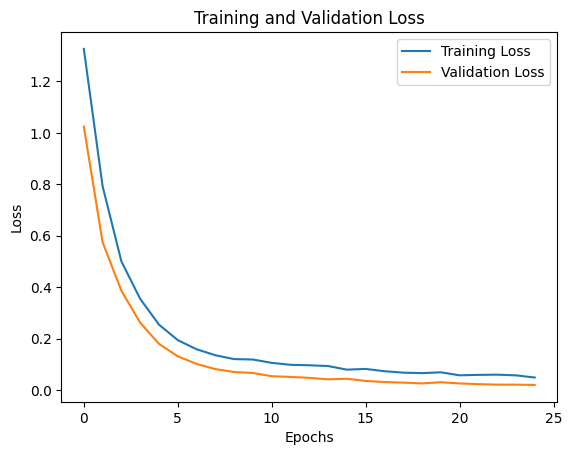

28/28 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       176
           1       1.00      1.00      1.00       177
           2       1.00      1.00      1.00       176
           3       0.98      1.00      0.99       176
           4       1.00      0.98      0.99       176

    accuracy                           1.00       881
   macro avg       1.00      1.00      1.00       881
weighted avg       1.00      1.00      1.00       881



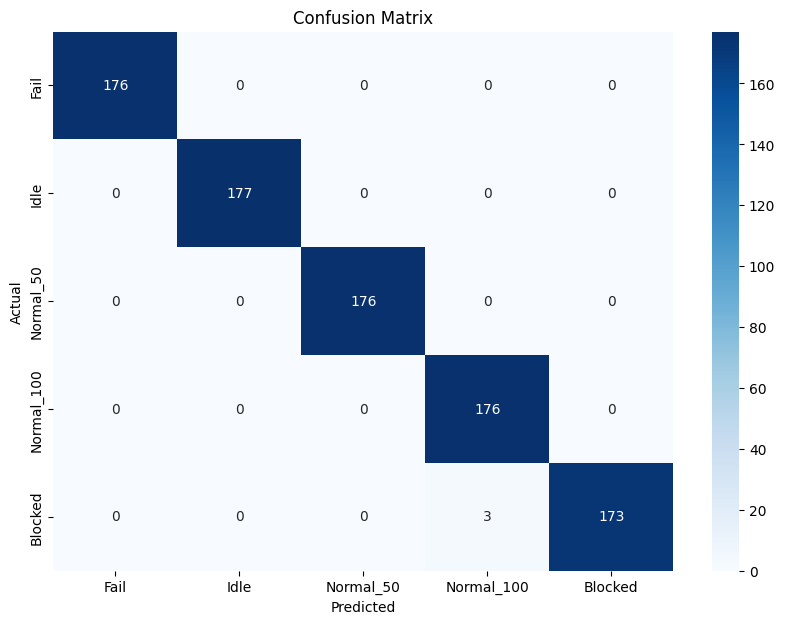

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 9, 16)             32        
                                                                 
 dropout (Dropout)           (None, 9, 16)             0         
                                                                 
 flatten (Flatten)           (None, 144)               0         
                                                                 
 dense (Dense)               (None, 20)                2900      
                                                                 
 dense_1 (Dense)             (None, 5)                 105       
                                                                 
Total params: 3037 (11.86 KB)
Trainable params: 3037 (11.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Example usage
all_features = [#'X_mean', 'Y_mean', 'Z_mean',
                'X_var', 'Y_var', 'Z_var',
                #'X_skew', 'Y_skew', 'Z_skew',
                'X_kurtosis', 'Y_kurtosis', 'Z_kurtosis',
                #'X_mad', 'Y_mad', 'Z_mad',
                'X_rms', 'Y_rms', 'Z_rms'
                #'X_fft_mean', 'Y_fft_mean', 'Z_fft_mean'
                #'X_fft_peak_freq', 'Y_fft_peak_freq', 'Z_fft_peak_freq',
                #'X_fft_peak_magnitude', 'Y_fft_peak_magnitude', 'Z_fft_peak_magnitude',
                #'X_fft_power_band_1', 'Y_fft_power_band_1', 'Z_fft_power_band_1',
                #'X_fft_power_band_2', 'Y_fft_power_band_2', 'Z_fft_power_band_2'
                ]

selected_features = all_features  # Select features

X_train, X_test, y_train, y_test, min_val, max_val = prepare_data(all_features_df, selected_features)

# Build the model
input_shape = (X_train.shape[1], 1)
num_classes = len(np.unique(y_train))
model = build_small_1d_cnn(input_shape, num_classes)

# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test))

# Plot training and validation loss
plot_loss(history)

# Evaluate the model on the test set
y_test_pred = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
print(classification_report(y_test, y_test_pred_classes, zero_division=0))

# Plot confusion matrix
class_labels = all_features_df['Class'].unique()
plot_confusion_matrix(y_test, y_test_pred_classes, class_labels)
model.summary()

In [ ]:
# Save the model into an HDF5 file ‘model.h5’
model.save('model.h5')
model.save('model.keras')
# Formatting and printing
formatted_array1 = [f"{x:.8f}," for x in min_val]
formatted_array2 = [f"{x:.8f}," for x in max_val]

print("{ " + " ".join(formatted_array1) + " }\n")
print("{ " + " ".join(formatted_array2) + " }")

{ 3.93651545, 3.12643647, 7.30293895, -1.17442311, -1.40820031, -1.07445165, 2.21700892, 2.07523060, 2.72764564, }

{ 29624.12505961, 394383.77018813, 221233.46882001, 0.88927006, 1.09869151, 5.80973034, 172.15439630, 628.05727881, 470.61498512, }


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



# Testing


In [ ]:
# URLs for dataset1 (køkkenbord)
idle_test = pd.read_csv(urls_test['idle'])
normal_50_test = pd.read_csv(urls_test['normal_50'])
normal_100_test = pd.read_csv(urls_test['normal_100'])
blocked_test = pd.read_csv(urls_test['blocked'])
fail_100_test = pd.read_csv(urls_test['fail_100'])

# Process all dataframes
fail_features_test = process_df(fail_100_test, sample_rate)
idle_features_test = process_df(idle_test, sample_rate)
normal_50_features_test = process_df(normal_50_test, sample_rate)
normal_100_features_test = process_df(normal_100_test, sample_rate)
blocked_features_test = process_df(blocked_test, sample_rate)

# Add classification labels
fail_features_test['Class'] = 'Fail'
idle_features_test['Class'] = 'Idle'
normal_50_features_test['Class'] = 'Normal_50'
normal_100_features_test['Class'] = 'Normal_100'
blocked_features_test['Class'] = 'Blocked'

# Combine all features into one DataFrame
all_features_test_df = pd.concat([fail_features_test, idle_features_test, normal_50_features_test, normal_100_features_test, blocked_features_test])

46/46 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       1.00      1.00      1.00       293
           2       1.00      1.00      1.00       292
           3       0.97      1.00      0.98       292
           4       1.00      0.97      0.98       292

    accuracy                           0.99      1461
   macro avg       0.99      0.99      0.99      1461
weighted avg       0.99      0.99      0.99      1461

['Fail' 'Idle' 'Normal_50' 'Normal_100' 'Blocked']


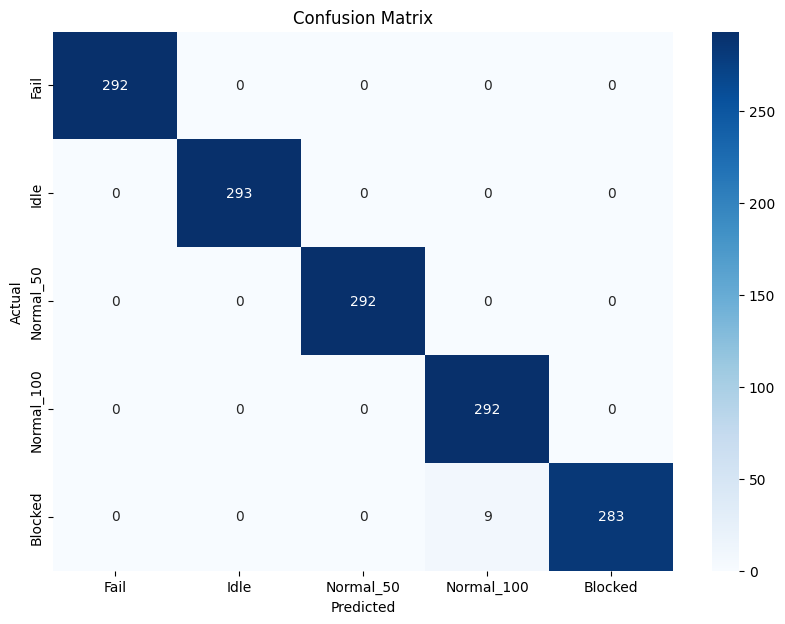

In [ ]:
# test
X_test_fail = all_features_test_df[selected_features].values
y_test_fail = all_features_test_df['Class'].factorize()[0]

# Normalize and reshape the fail test data
X_test_fail = (X_test_fail - min_val) / (max_val - min_val)
#X_test_fail = X_test_fail.reshape((X_test_fail.shape[0], X_test_fail.shape[1], 1))

# Evaluate the model on the test set
y_test_pred = model.predict(X_test_fail)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
print(classification_report(y_test_fail, y_test_pred_classes))

# Plot confusion matrix
class_labels = all_features_df['Class'].unique()
print(class_labels)
plot_confusion_matrix(y_test_fail, y_test_pred_classes, class_labels)

In [ ]:
# plot_3d_scatter_features(all_features_test_df, 'X_mean', 'Y_mean', 'Z_mean', '3D Scatter Plot of Mean Features')
# plot_3d_scatter_features(all_features_test_df, 'X_var', 'Y_var', 'Z_var', '3D Scatter Plot of Variance Features')
# plot_3d_scatter_features(all_features_test_df, 'X_skew', 'Y_skew', 'Z_skew', '3D Scatter Plot of Skewness Features')
# plot_3d_scatter_features(all_features_test_df, 'X_kurtosis', 'Y_kurtosis', 'Z_kurtosis', '3D Scatter Plot of Kurtosis Features')
# plot_3d_scatter_features(all_features_test_df, 'X_mad', 'Y_mad', 'Z_mad', '3D Scatter Plot of MAD Features')
# plot_3d_scatter_features(all_features_test_df, 'X_rms', 'Y_rms', 'Z_rms', '3D Scatter Plot of RMS Features')
# plot_3d_scatter_features(all_features_test_df, 'X_fft_mean', 'Y_fft_mean', 'Z_fft_mean', '3D Scatter Plot of FFT Mean Features')
# plot_3d_scatter_features(all_features_test_df, 'X_fft_var', 'Y_fft_var', 'Z_fft_var', '3D Scatter Plot of FFT Variance Features')
# plot_3d_scatter_features(all_features_test_df, 'X_fft_peak_freq', 'Y_fft_peak_freq', 'Z_fft_peak_freq', '3D Scatter Plot of FFT Peak Frequencies')
# plot_3d_scatter_features(all_features_test_df, 'X_fft_peak_magnitude', 'Y_fft_peak_magnitude', 'Z_fft_peak_magnitude', '3D Scatter Plot of FFT Peak Magnitudes')
# plot_3d_scatter_features(all_features_test_df, 'X_fft_power_band_1', 'Y_fft_power_band_1', 'Z_fft_power_band_1', '3D Scatter Plot of FFT Power Band 1')
# plot_3d_scatter_features(all_features_test_df, 'X_fft_power_band_2', 'Y_fft_power_band_2', 'Z_fft_power_band_2', '3D Scatter Plot of FFT Power Band 2')

In [ ]:
all_features_df[selected_features]

,X_var,Y_var,Z_var,X_kurtosis,Y_kurtosis,Z_kurtosis,X_rms,Y_rms,Z_rms
0,23132.363714,269468.704085,114712.165483,-0.763362,-1.321253,-0.490601,152.223523,519.119982,338.693184
1,22991.121709,271927.358098,109689.513246,-0.777512,-1.321638,-0.618769,151.751694,521.503185,331.202109
2,22361.727655,272289.842959,108778.890026,-0.814456,-1.330571,-0.563659,149.661832,521.879969,329.822356
3,22661.962759,269379.138328,117881.447905,-0.802097,-1.323369,-0.547181,150.635324,519.106643,343.338680
4,22978.348012,270386.906876,122593.505065,-0.793162,-1.323881,-0.660786,151.627704,520.068479,350.137017
...,...,...,...,...,...,...,...,...,...
875,3018.945701,11639.288059,45374.940320,0.203540,0.443705,-0.531348,54.964434,107.900067,213.353961
876,3020.240492,11165.245728,43663.225882,0.142938,0.399685,-0.531149,54.967726,105.684066,209.417487
877,3235.209813,11267.252279,44586.143270,0.602297,0.255410,-0.468274,56.904382,106.156876,211.361496
878,3151.382084,11431.700294,48192.473773,0.475986,0.222510,-0.501840,56.154375,106.966364,219.762084


In [ ]:
single_data_point = {
    'X_var': 23132.363714, 'Y_var': 269468.704085, 'Z_var': 114712.165483,
    'X_kurtosis': -0.763362, 'Y_kurtosis': -1.321253	, 'Z_kurtosis': -0.490601,
    'X_rms': 152.223523, 'Y_rms': 519.119982, 'Z_rms': 338.693184
}

data_array = np.array([
    single_data_point['X_var'], single_data_point['Y_var'], single_data_point['Z_var'],
    single_data_point['X_kurtosis'], single_data_point['Y_kurtosis'], single_data_point['Z_kurtosis'],
    single_data_point['X_rms'], single_data_point['Y_rms'], single_data_point['Z_rms']
])

print(data_array.shape)

normalized_data = (data_array - min_val) / (max_val - min_val)

reshaped_data = normalized_data.reshape(1, 9)
print(reshaped_data)

prediction = model.predict(reshaped_data)
predicted_class = np.argmax(prediction, axis=1)

print(predicted_class)


(9,)
[[0.78083322 0.68326269 0.51849591 0.19918712 0.03468331 0.08481046
  0.88271637 0.82597377 0.71804794]]
1/1 [==============================] - 0s 21ms/step
[0]
